In [1]:
%matplotlib inline

In [2]:
%env JAX_ENABLE_X64=1
%env JAX_PLATFORM_NAME=cpu

env: JAX_ENABLE_X64=1
env: JAX_PLATFORM_NAME=cpu


In [3]:
import jax
import jax.numpy as jnp
from jax import jit, grad

In [4]:
import matplotlib.pyplot as plt

plt.style.use('classic')
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

In [5]:
import os
import pickle
from functools import reduce

# Constants

In [6]:
# model size (MPS_SIZE * LOCAL_DIM + BOND_DIM = TRAIN_SIZE)
MPS_SIZE = 4
LOCAL_DIM = 4
BOND_DIM = 6

# APPROX RANK
APPROX_RANK = range(2,11,2)

# SAVE/PRINT after that many epochs
SAVE_AFTER_EPOCHS = 50

# Helpers

In [7]:
from collections import defaultdict

def idict():
    """Infinitely nested dict"""
    return defaultdict(idict)

def idict2dict(dic):
    if isinstance(dic, defaultdict):
        dic = {k: idict2dict(v) for k, v in dic.items()}
    return dic

# Load results

In [8]:
exp_dir = 'experiment/rmse-loss/20220315-noise-5'

lrn_dir = os.path.join(exp_dir, 'learning')
res_dir = os.path.join(exp_dir, 'results')
fig_dir = os.path.join(exp_dir, 'figs')

file_path = os.path.join(res_dir, 'loss.pkl')

with open(file_path, 'rb') as f:
    results = pickle.load(f)

In [9]:
fig_dir = os.path.join(exp_dir, 'figs')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [10]:
import matplotlib.ticker as mticker

def plot_epochs_curve(results, title):
    # converting into a dict
    results = idict2dict(results)
    for smpl_size, res in results.items():
        data = [r.item() for r in res]
        plt.plot(data, label=f'Rank-{smpl_size}', linewidth=3)
    plt.grid(True)
    xticks_values = [int(l*SAVE_AFTER_EPOCHS) for l in plt.gca().get_xticks()]
    # plt.axes().xaxis.set_major_locator(mticker.FixedLocator(xticks_values))
    plt.gca().set_xticklabels(xticks_values)
    # plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0)) 
    # plt.gca().xaxis.set_major_formatter(
    #     plt.matplotlib.ticker.StrMethodFormatter("{x:.0f}00")
    # )
    # Hide first 0 in xticks
    xticks = plt.gca().xaxis.get_major_ticks()
    xticks[0].label1.set_visible(False)
    plt.legend()
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Risk', fontsize=20)
    plt.title(title, fontsize=24)
    plt.savefig(os.path.join(fig_dir, f'epochs-curve-{title.lower()}.png'))
    plt.show()

<ipython-input-10-746974568806>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(xticks_values)


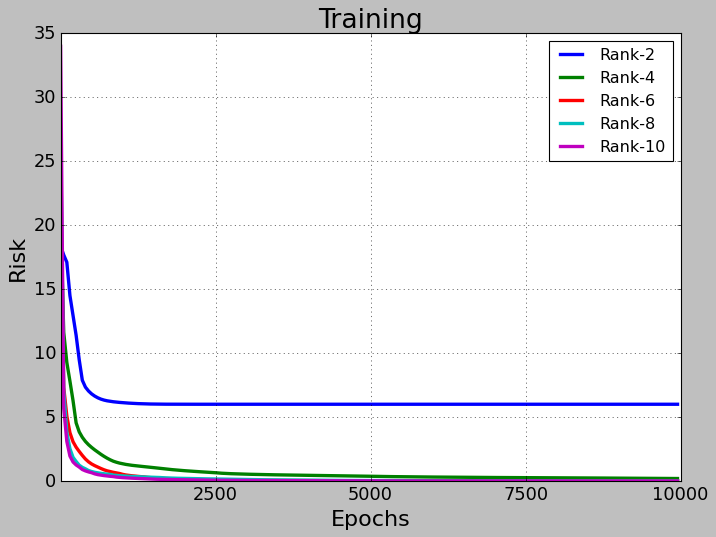

In [11]:
plt.rcParams["figure.figsize"] = (10,7)
plot_epochs_curve(results['train'], title='Training')

<ipython-input-10-746974568806>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(xticks_values)


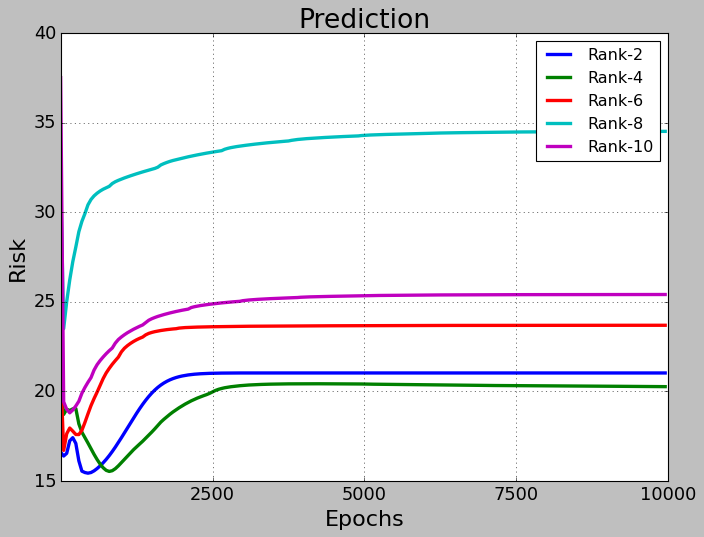

In [12]:
plt.rcParams["figure.figsize"] = (9.8,7)
plot_epochs_curve(results['test'], title='Prediction')


In [13]:
def plot_approx_rank_curve(results, title):
    # converting into a dict
    results = idict2dict(results)
    data = {k:jnp.mean(jnp.asarray(vs[-100:])).item() for k,vs in results.items()}
    x, y = zip(*data.items())
    plt.plot(x, y, 'o-', color='blue', linewidth=3)
    plt.grid(True)
    plt.xlabel('Approximation Rank', fontsize=20)
    plt.ylabel('Risk', fontsize=20)
    plt.title(title, fontsize=24)
    plt.savefig(os.path.join(fig_dir, f'approx-rank-curve-{title.lower()}.png'))
    plt.show()

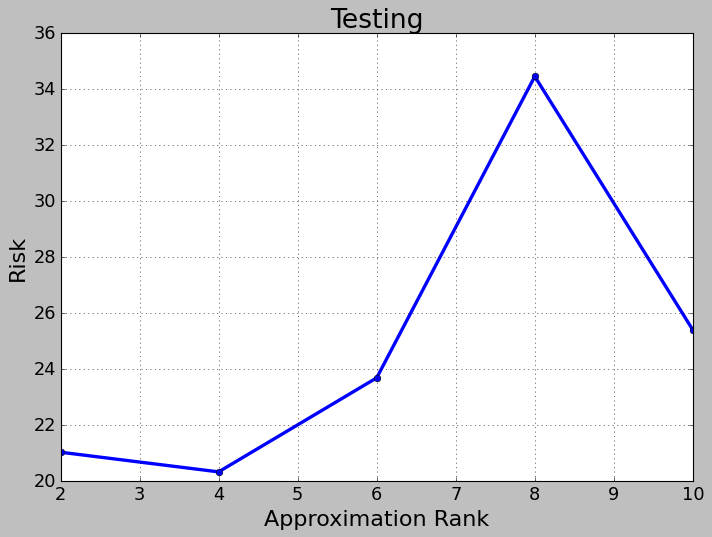

In [14]:
plt.rcParams["figure.figsize"] = (10.2,7)
plot_approx_rank_curve(results['test'], title='Testing')

# Calculating the environment spectrum

In [15]:
def fully_contract(mps):
    """Fully contract the MPS with its conjugate."""
    tensors = [jnp.einsum('pqr,uqv->purv', t, t.conj()) for t in mps]
    res = reduce(lambda x,y: jnp.einsum('purv,rvts->puts', x,y), tensors)
    return res.squeeze()

In [16]:
def e_spec_env(params, i=0):
    """Compute the entanglement spectrum of each tensor with the environment."""
    # The idea is to use MPS and MPS* and connect all the physical legs except one (indexed by i).
    # The construction results in a matrix of dimension d x d where d is physical dimension.
    # The result descibes the spectrum of the entanglement of that tensor with the whole environment.
    assert isinstance(params, list), 'Expecting a list type'
    assert 0 <= i <= len(params)-1,  'Bad index => must be 0 <= i <= len(params)-1'
    
    if len(params) == 1:
        mat = jnp.einsum('par,pbr->ab', p, p.conj())
    
    if i == 0:
        right = fully_contract(params[1:])
        if right.ndim == 0:
            right = right * jnp.eye(2)
        mat = jnp.einsum('par,ubv,rv->paub', params[0], params[0].conj(), right)
    elif i == len(params) - 1:
        left = fully_contract(params[:-1])
        if left.ndim == 0:
            left = left * jnp.eye(2)
        mat = jnp.einsum('pu,par,ubv->ravb', left, params[-1], params[-1].conj())
    else: 
        left = fully_contract(params[:i])
        if left.ndim == 0:
            left = left * jnp.eye(2)
        
        right = fully_contract(params[i+1:])
        if right.ndim == 0:
            right = right * jnp.eye(2)  

        mat = jnp.einsum('pu,par,ubv,rv->ab', left, params[i], params[i].conj(), right)

    mat = mat.squeeze()
    _, s, _ = jnp.linalg.svd(mat)
    
    return s

def e_entropy(params, i):
    """Compute the entanglement entropy of a bipartition between i and i+1."""

    assert isinstance(params, list), 'Expecting a list type'
    assert 1 <= i <= len(params)-1,  'Bad index => must be 1 <= i <= len(params) - 1'
    
    if len(params) == 1:
        raise ValueError('The MPS has one site only')
    
    left = fully_contract(params[:i])
    if left.ndim == 0:
        left = left * jnp.eye(2)

    right = fully_contract(params[i:])
    if right.ndim == 0:
        right = right * jnp.eye(2)
    
    # full density matrix
    rho = jnp.einsum('pq,uv->pquv', left, right)
    # reduced density matrix
    rho_a = jnp.einsum('piui->pu', rho)
    
    _, s, _ = jnp.linalg.svd(rho_a)
    entropy = -jnp.sum(s*jnp.log2(s))
    
    return entropy

# Loading parameters

In [17]:
import re

params_dir = os.path.join(lrn_dir, 'approx_rank')

env_spectrum = idict()
ent_entropy = idict()
for approx_rank in APPROX_RANK:
    dir_path = os.path.join(f'{params_dir}_{approx_rank}')
    files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) 
             if os.path.isfile(os.path.join(dir_path, f))]
    # sort by step to make the ordering correct
    files.sort(key=lambda f: int(re.sub('\D', '', f)))
    for step, params_file in enumerate(files):
        with open(params_file, 'rb') as f:
            params = pickle.load(f)
        # entanglement spectrum environment
        es = [e_spec_env(params,i) for i in range(MPS_SIZE)]
        env_spectrum[approx_rank][step] = es
        # entanglement entropy bipartitions
        ee = [e_entropy(params, i) for i in range(1,MPS_SIZE)]
        ent_entropy[approx_rank][step] = ee

In [18]:
def plot_entanglement_env_spectrum(data, title):
    
    t, s, i = data.shape

    cols = t//2

    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.suptitle(title, fontsize=24)
    plt.subplots_adjust(hspace = 0.15, wspace=0.1)
    for i in range(t):
        pid = (i//cols, i%cols) # plot id
        for j in range(s):
            axs[pid].plot(data[i,j,:], linewidth=3, label=r'$\lambda_{}$'.format(j+1))
            axs[pid].set_title(f'Tensor {i+1}', fontsize=16)
            axs[pid].grid(True)
            axs[pid].legend()
            axs[pid].tick_params(axis='both', which='major', labelsize=12)
            axs[pid].tick_params(axis='both', which='minor', labelsize=10)
            axs[pid].ticklabel_format(axis='y', style='sci', scilimits=(4,4))
            # axs[pid].xaxis.set_ticks_position('none')            
            # axs[pid].yaxis.set_ticks_position('none')            
            
    for ax in axs.flat:
        ax.set_xlabel(xlabel='Epochs', fontsize=16)
        xticks = ax.xaxis.get_major_ticks()
        xticks[0].label1.set_visible(False)

    for ax in axs.flat:
        ax.label_outer()
    
    xticks_values = [int(l*50) for l in plt.gca().get_xticks()]
    plt.gca().set_xticklabels(xticks_values)
    # plt.gca().xaxis.set_major_formatter(
    #     plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}00')
    # )
    # # Hide first 0 in xticks
    # xticks = plt.gca().xaxis.get_major_ticks()
    # xticks[0].label1.set_visible(False)
    
    plt.savefig(os.path.join(fig_dir, f'entanglement-spectra-{title.lower()}.png'))

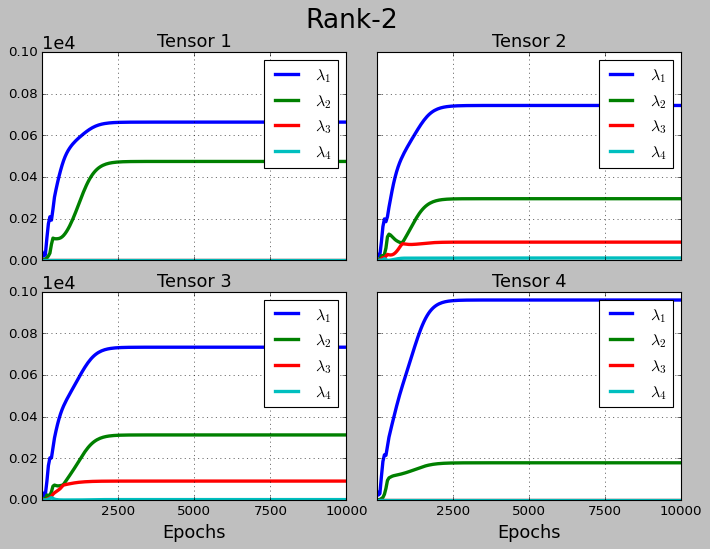

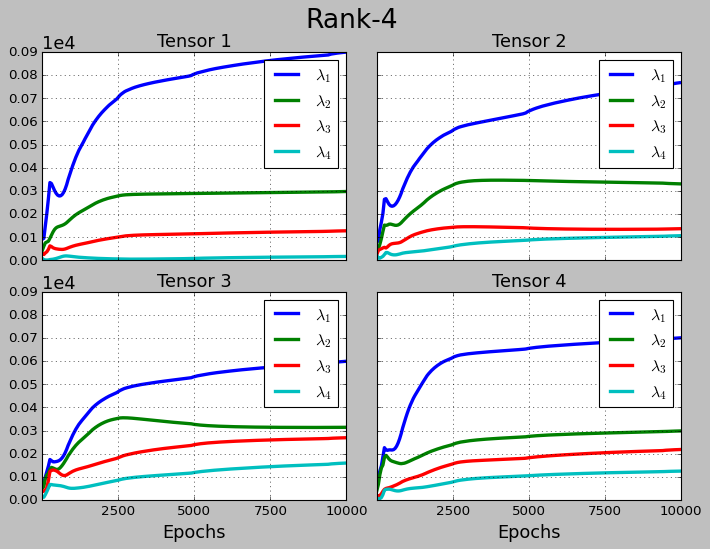

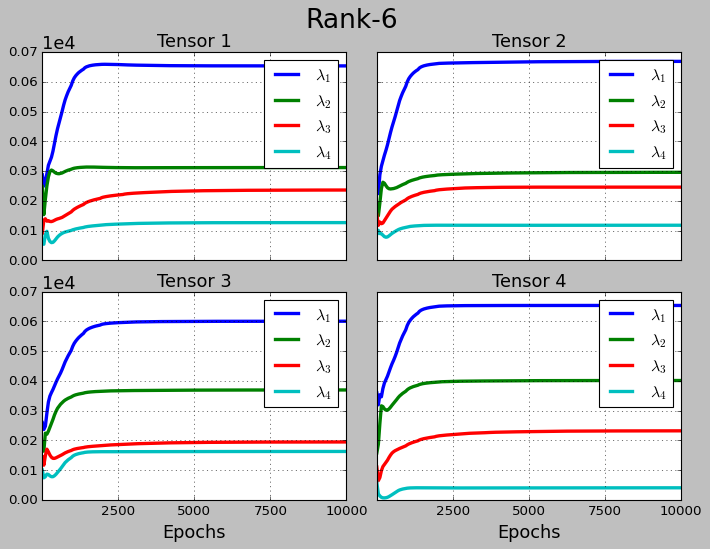

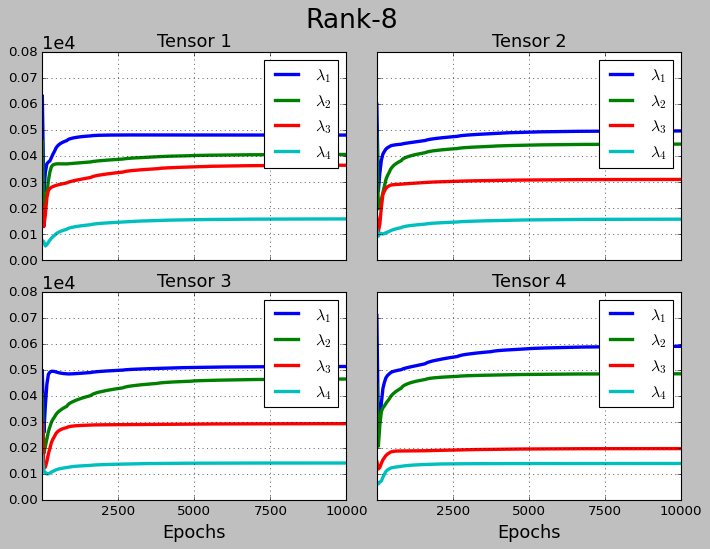

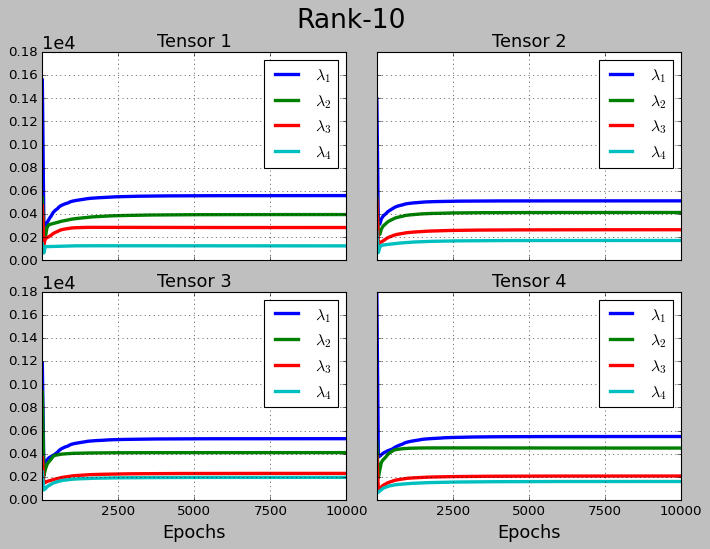

In [19]:
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (10.3,7)

for approx_rank in APPROX_RANK:
    S = env_spectrum[approx_rank]
    data = jnp.array(list(S.values())).transpose(1,2,0)  
    plot_entanglement_env_spectrum(data, title=f'Rank-{approx_rank}')

# Entanglement Entropy for Bipartitions

In [20]:
def plot_entanglement_entropy(results, title):
    fig, axs = plt.subplots(len(APPROX_RANK), 1, sharex=True, sharey=False)
    fig.suptitle(title, fontsize=24)
    plt.subplots_adjust(hspace = 0.15, wspace=0.1)
    results = idict2dict(results)
    for pid, (rank, data) in enumerate(results.items()):
        _, vals_ = zip(*data.items())
        vals = jnp.asarray(vals_).T
        axs[pid].plot(vals[0,:], linewidth=3, label='1-2 bond')
        axs[pid].plot(vals[1,:], linewidth=3, label='2-3 bond')        
        axs[pid].plot(vals[2,:], linewidth=3, label='3-4 bond')
        # axs[pid].plot(vals, linewidth=3)
        axs[pid].grid(True)
        axs[pid].legend()
        axs[pid].ticklabel_format(axis='y', style='sci', scilimits=(4,4))
        axs[pid].set_title(f'Rank {rank}', fontsize=16)
        axs[pid].tick_params(axis='both', which='major', labelsize=12)
        # axs[pid].set_xlabel(xlabel='Epochs', fontsize=16)
    
    xticks_values = [int(l*50) for l in plt.gca().get_xticks()]
    plt.gca().set_xticklabels(xticks_values)
    plt.gca().set_xlabel(xlabel='Epochs', fontsize=16)

    plt.subplots_adjust(top=0.955)
   
    # for ax in axs.flat:
    #     ax.set_xlabel(xlabel='Epochs', fontsize=16)
    #     xticks = ax.xaxis.get_major_ticks()
    #     xticks[0].label1.set_visible(False)
    
    
    plt.show()

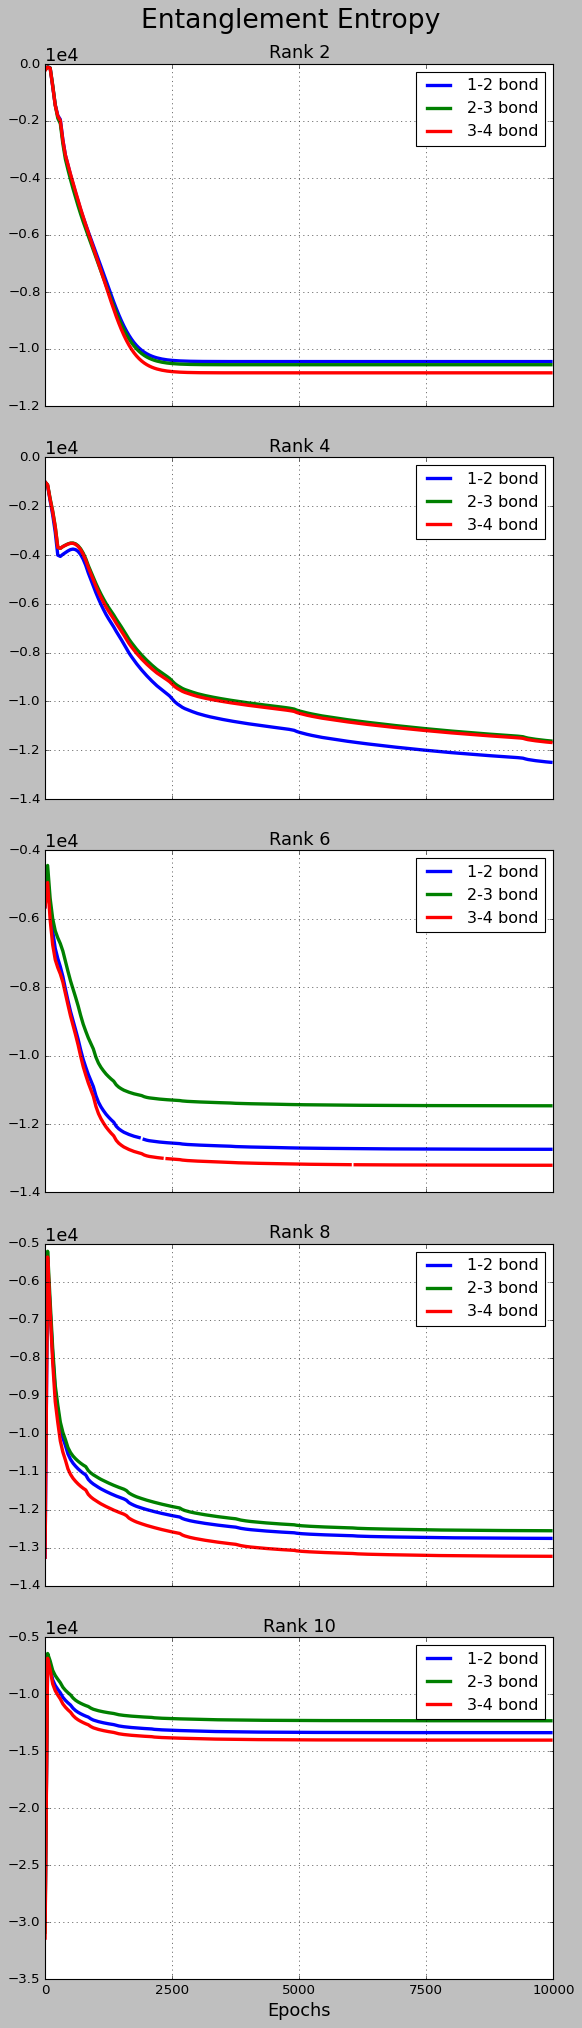

In [21]:
plt.rcParams["figure.figsize"] = (8.2,28)

plot_entanglement_entropy(ent_entropy, "Entanglement Entropy")

In [22]:
# i=1
# left = mps_norm(params[:i])
# right = mps_norm(params[i:])
# rho = jnp.einsum('pq,uv->pquv', left, right)
# rho_a = jnp.einsum('piui->pu', rho)
# rho_b = jnp.einsum('iqiv->qv', rho)
# assert jnp.allclose(rho_a, rho_b)

# _, s, _ = jnp.linalg.svd(rho_a)
# entropy = -jnp.sum(s*jnp.log2(s))
# entropy